Importing necessary Python libraries and setting seaborn styling.

In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

sns.set(context="notebook", style="darkgrid", palette="deep", font="sans-serif", font_scale=1, color_codes=True, rc=None)

Now let's load in our cirrhosis data and take a preliminary look.

In [83]:
data = pd.read_csv("../data/cirrhosis.csv")

data.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [84]:
data.shape

(418, 20)

In [85]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,418.0,209.500000,120.810458,1.00,105.2500,209.50,313.75,418.00
N_Days,418.0,1917.782297,1104.672992,41.00,1092.7500,1730.00,2613.50,4795.00
Age,418.0,18533.351675,3815.845055,9598.00,15644.5000,18628.00,21272.50,28650.00
Bilirubin,418.0,3.220813,4.407506,0.30,0.8000,1.40,3.40,28.00
Cholesterol,284.0,369.510563,231.944545,120.00,249.5000,309.50,400.00,1775.00
Albumin,418.0,3.497440,0.424972,1.96,3.2425,3.53,3.77,4.64
Copper,310.0,97.648387,85.613920,4.00,41.2500,73.00,123.00,588.00
Alk_Phos,312.0,1982.655769,2140.388824,289.00,871.5000,1259.00,1980.00,13862.40
SGOT,312.0,122.556346,56.699525,26.35,80.6000,114.70,151.90,457.25
Tryglicerides,282.0,124.702128,65.148639,33.00,84.2500,108.00,151.00,598.00


In [86]:
data.describe(exclude="number").T

,count,unique,top,freq
Status,418,3,C,232
Drug,312,2,D-penicillamine,158
Sex,418,2,F,374
Ascites,312,2,N,288
Hepatomegaly,312,2,Y,160
Spiders,312,2,N,222
Edema,418,3,N,354


As you can see from our data, we have 418 rows with 20 columns. Each of these rows represents a patient undergoing trial for the drug D-penicillamine. Under the Drug column, we can see that some patients were given the drug, and others were given a placebo.

Now that we've taken a look at the data we'll be working with, let's start to handle any missing values that may be present.

In [87]:
# Calculating the proportion of missing values in each column relative to the entire dataset rounded to two decimal places
round(data.isnull().sum()/len(data), 2)

ID               0.00
N_Days           0.00
Status           0.00
Drug             0.25
Age              0.00
Sex              0.00
Ascites          0.25
Hepatomegaly     0.25
Spiders          0.25
Edema            0.00
Bilirubin        0.00
Cholesterol      0.32
Albumin          0.00
Copper           0.26
Alk_Phos         0.25
SGOT             0.25
Tryglicerides    0.33
Platelets        0.03
Prothrombin      0.00
Stage            0.01
dtype: float64

Now we can verify that there are indeed missing values within our dataset. Some columns don't have any missing values (indicated by a value of 0.00 above), but other columns contain updwards of 33% missing values. In order to make use of this dataset, we need to fill those missing values. I have decided to fill the categorical columns with the mode value for each column and the numerical columns with the median value for each column. Doing so will ensure that the appropriate placeholder values are used.

In [88]:
# Filling categorical columns with the most frequent (mode) value for each respective column
data["Drug"].fillna("D-penicillamine", inplace=True)
data["Ascites"].fillna("N", inplace=True)
data["Hepatomegaly"].fillna("Y", inplace=True)
data["Spiders"].fillna("N", inplace=True)
data["Stage"].fillna(3.0, inplace=True)

# Filling numerical columns with the middle value (median) for each respective column
data["Cholesterol"].fillna(309.5, inplace=True)
data["Copper"].fillna(73, inplace=True)
data["Alk_Phos"].fillna(1259, inplace=True)
data["SGOT"].fillna(114.7, inplace=True)
data["Tryglicerides"].fillna(108, inplace=True)
data["Platelets"].fillna(251, inplace=True)
data["Prothrombin"].fillna(10.60, inplace=True)

Now let's start visualizing our constructed data.

In [89]:
# Calculating the number of bins to use in our histogram
n_bins = int(math.sqrt(len(data["N_Days"])))
n_bins

20

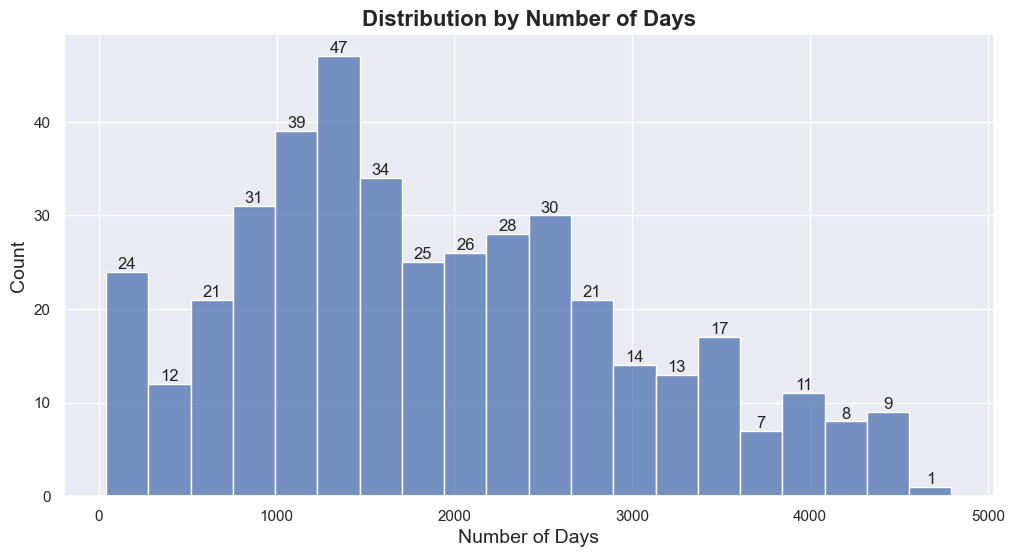

In [90]:
# Utilizing seaborn to plot a histogram distribution of the number of days
plt.figure(figsize=(12, 6))
plt.title("Distribution by Number of Days", fontsize=16, fontweight="bold")
ax = sns.histplot(data["N_Days"], bins=n_bins)
plt.xlabel("Number of Days", fontsize=14)
plt.ylabel("Count", fontsize=14)
for lab in ax.containers:
    ax.bar_label(lab)

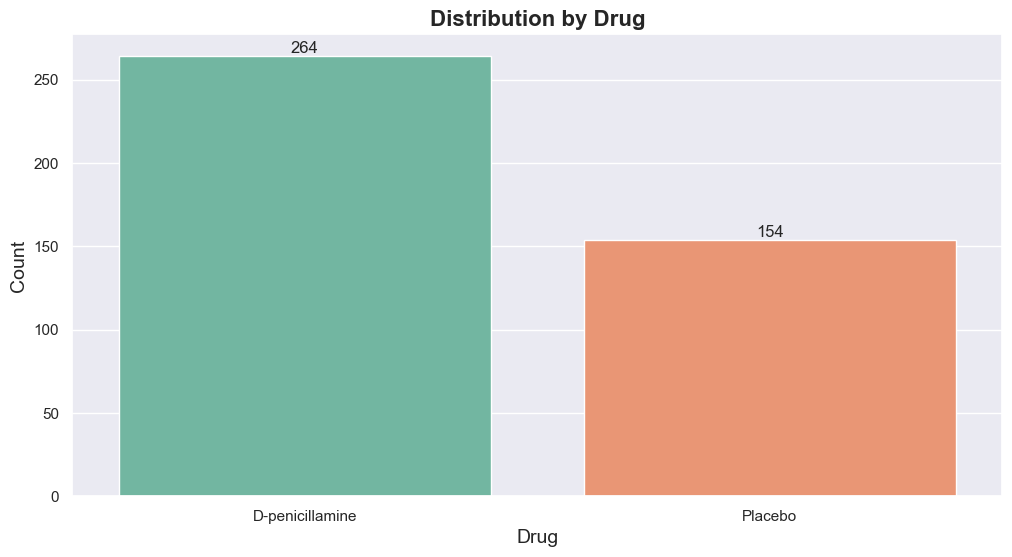

In [91]:
# Utilizing seaborn to plot a count distribution of the drug
plt.figure(figsize=(12,6))
plt.title("Distribution by Drug", fontsize=16, fontweight="bold")
ax = sns.countplot(x=data["Drug"], hue=data["Drug"], palette="Set2", legend=False)
plt.xlabel("Drug", fontsize=14)
plt.ylabel("Count", fontsize=14)
for lab in ax.containers:
    ax.bar_label(lab)

In [92]:
# Convering age from days to years
data["Age"] = data["Age"] / 365

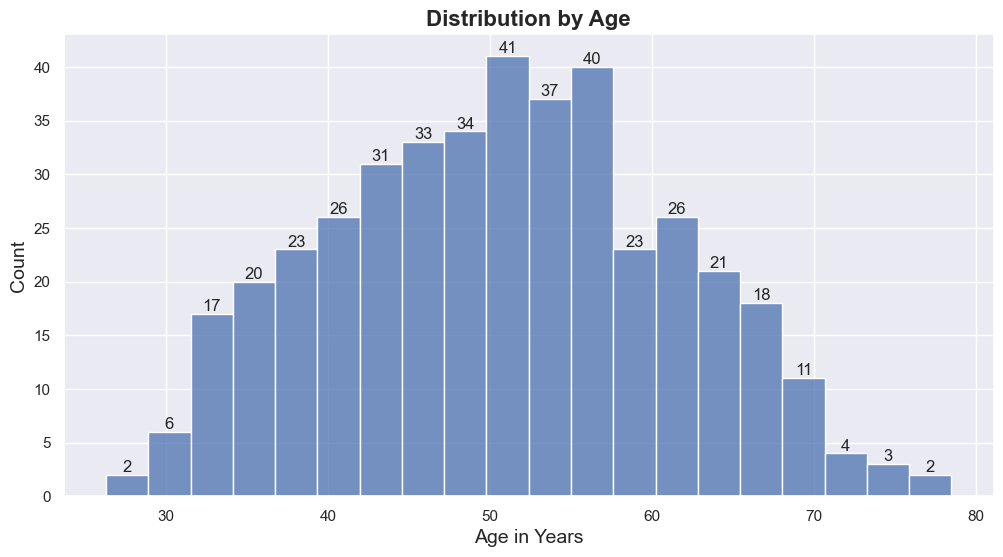

In [93]:
# Utilizing seaborn to plot a histogram distribution of age
plt.figure(figsize=(12, 6))
plt.title("Distribution by Age", fontsize=16, fontweight="bold")
ax = sns.histplot(data["Age"], bins=n_bins)
plt.xlabel("Age in Years", fontsize=14)
plt.ylabel("Count", fontsize=14)
for lab in ax.containers:
    ax.bar_label(lab)

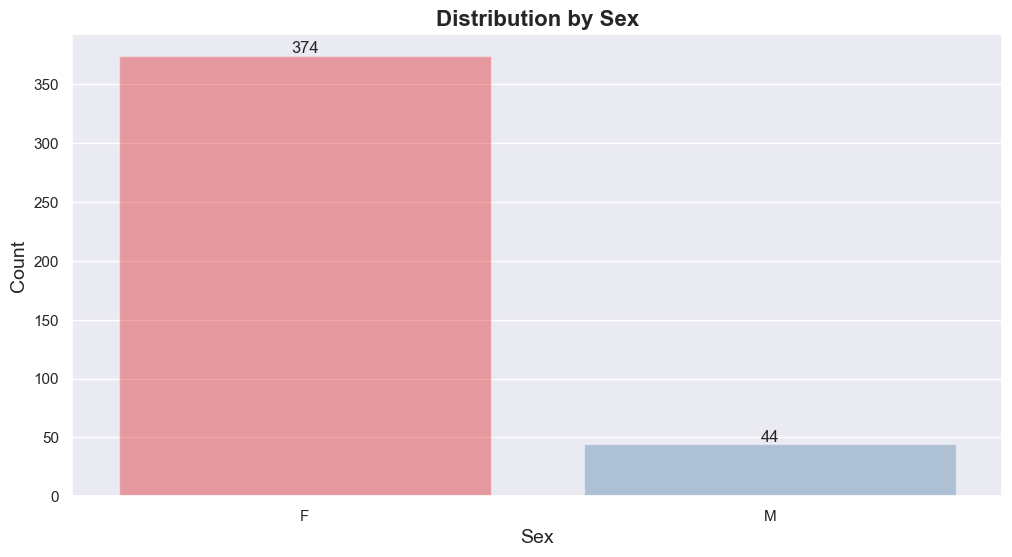

In [94]:
# Utilizing seaborn to plot a count distribution of sex
plt.figure(figsize=(12, 6))
plt.title("Distribution by Sex", fontsize=16, fontweight="bold")
ax = sns.countplot(x=data["Sex"], data=data, hue="Sex", palette={"F": "red", "M": "steelblue"}, legend=False, alpha=0.4)
plt.xlabel("Sex", fontsize=14)
plt.ylabel("Count", fontsize=14)
for lab in ax.containers:
    ax.bar_label(lab)

From our distribution by sex, there are significantly more Females than Males in our dataset. Let's see how this affects our data.

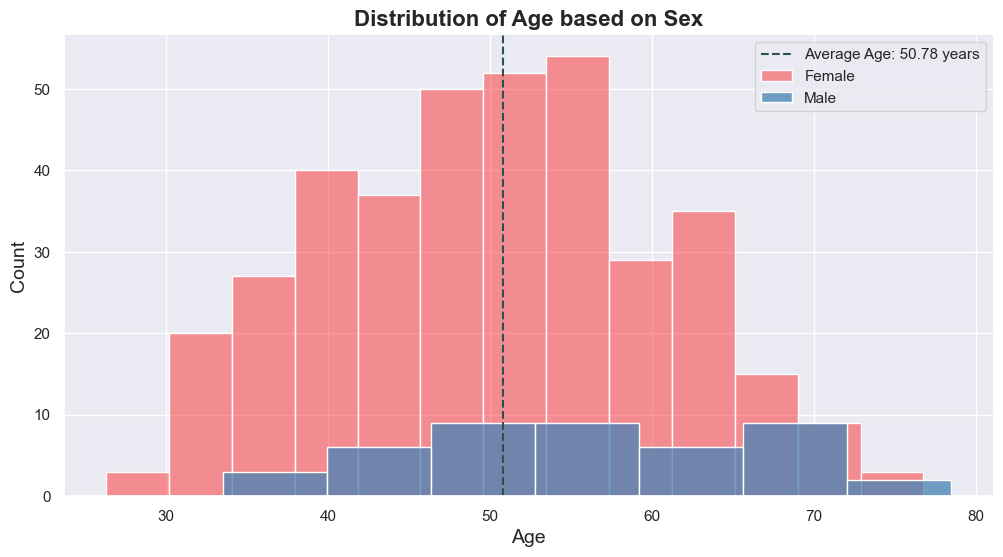

In [95]:
# Calculating average age
avg_age = np.mean(data["Age"])

plt.figure(figsize=(12,6))
plt.title("Distribution of Age based on Sex", fontsize=16, fontweight="bold")
sns.histplot(data[data["Sex"] == "F"]["Age"], label="Female", color="red", alpha=0.4)
sns.histplot(data[data["Sex"] == "M"]["Age"], label="Male", color="steelblue")
plt.axvline(x=avg_age, color="#2F4F4F", linestyle="--", label=f"Average Age: {avg_age:.2f} years")
plt.xlabel("Age", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend()

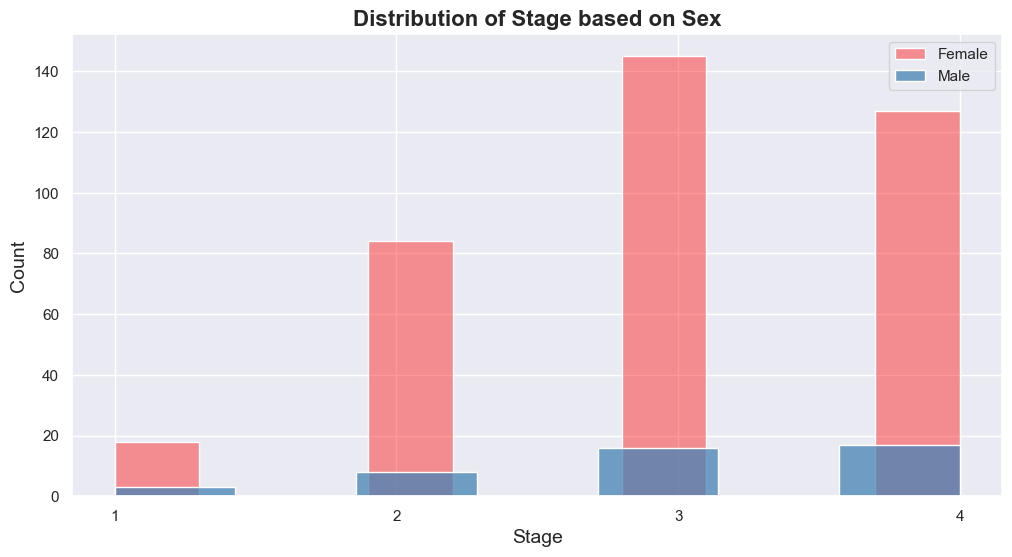

In [96]:
#Distribution plot of stage of 
plt.figure(figsize=(12,6))
plt.title("Distribution of Stage based on Sex", fontsize=16, fontweight="bold")
sns.histplot(data[data["Sex"] == "F"]["Stage"], label="Female", color="red", alpha=0.4)
sns.histplot(data[data["Sex"] == "M"]["Stage"], label="Male", color="steelblue")
plt.xlabel("Stage", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(ticks=[1, 2, 3, 4])
plt.legend()

Now it's time to transform our data to prepare it for prediction analysis.

In [97]:
# Data transformation, replacing String values
data["Status"].replace({"C":0, "CL":1, "D":2}, inplace=True)
data["Drug"].replace({"D-penicillamine":0, "Placebo":1}, inplace=True)
data["Sex"].replace({"F":0, "M":1}, inplace=True)
data["Ascites"].replace({"N":0, "Y":1}, inplace=True)
data["Hepatomegaly"].replace({"N":0, "Y":1}, inplace=True)
data["Spiders"].replace({"N":0, "Y":1}, inplace=True)
data["Edema"].replace({"N":0, "S":1, "Y":2}, inplace=True)

Checking correlation to identify relationships between variables. The darker squares represent a stronger correlation, with the positive numbers being positive correlations of course and the negative being negative correlations. 

<AxesSubplot:>

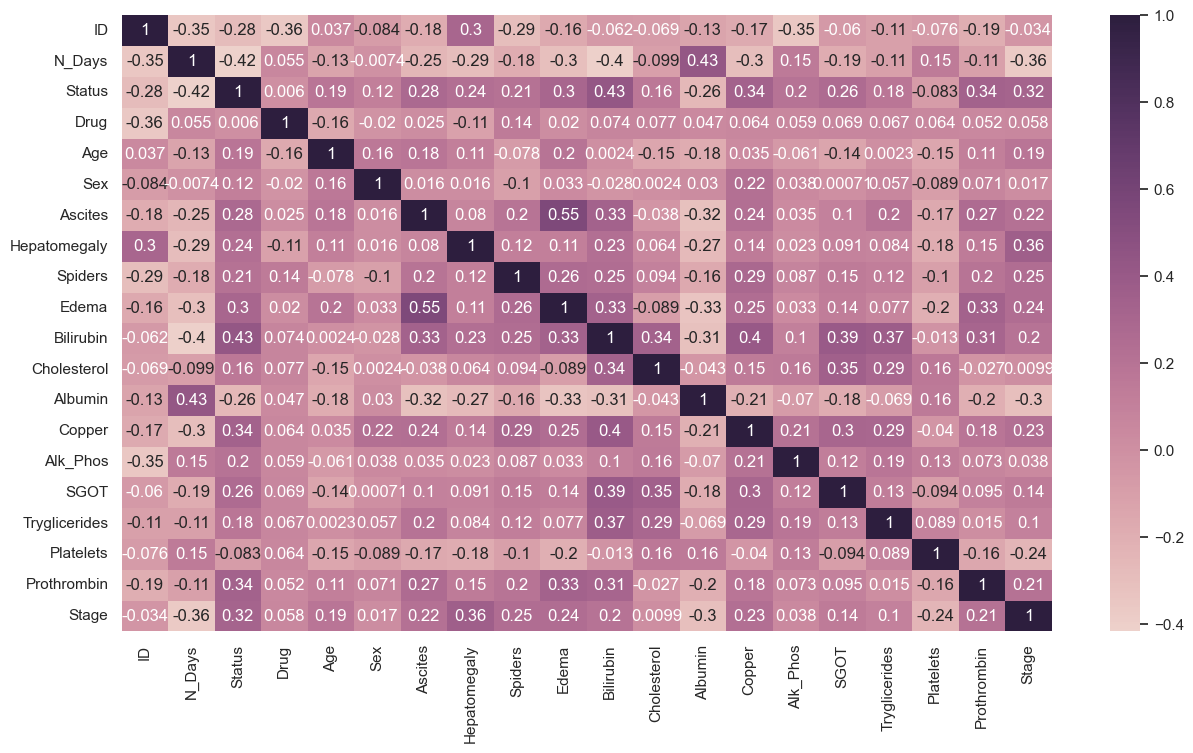

In [98]:
plt.figure(figsize=(15, 8))
sns.heatmap(data.corr(), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))

Now let's define what our target variable will be. What are we most interested in predicting? There are several variables to choose from, both in binary classifications and multiclass classifications. However, I've decided to pursue the status of the patient as the target. There are three possible classifications for the Status of a patient. C (censored), CL (censored due to liver tx), or D (death).

In [99]:
# Defining target variable as Status
X = data.drop(['Status'], axis=1)
y = data['Status']

To identify what model inputs have the greatest relationship to the outputs you can create a feature score barplot. A higher score means that the specific feature will have a greater impact on the model being used to predict our target variable.

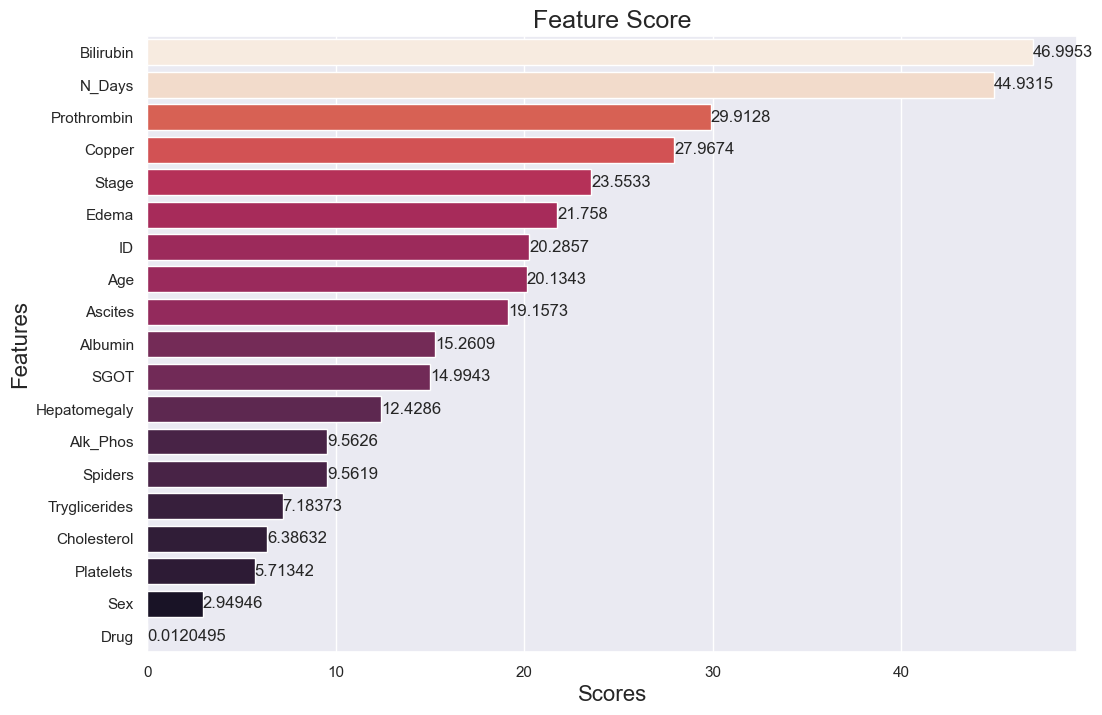

In [100]:
# Feature engineering
selector = SelectKBest(f_classif, k=19)
X_selected = selector.fit_transform(X,y)

# Creating list of all the columns and their score in variables
selected_features = X.columns[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]

# Creating new Dataframe to store features and their scores
feature_score_df = pd.DataFrame({"Features": selected_features, "Scores": feature_scores})

# Sorting Dataframe in descending order
feature_score_df = feature_score_df.sort_values(by="Scores", ascending=False)

# Features and scores barplot
plt.figure(figsize=(12,8))
ax = sns.barplot(x=feature_score_df["Scores"], y=feature_score_df["Features"], hue=feature_score_df["Scores"], palette="rocket", legend=False)
plt.title("Feature Score", fontsize=18)
plt.xlabel("Scores", fontsize=16)
plt.ylabel("Features", fontsize=16)
for lab in ax.containers:
    ax.bar_label(lab)

Accoring to the feature score plot above, Bilirubin and N_Days have the greatest relationship. Now I will drop the lowest feature score variables from our data.

In [101]:
# Dropping lowest feature scores
X = X.drop(["Drug", "Sex", "Platelets", "Cholesterol", "Tryglicerides"], axis=1)

Before we can start splitting our data into the training and testing groups, we must scale the data. Scaling data is important because it helps ensure that all features used contribute equally to the learning process of our model.

In [102]:
# Scaling the data
col = X.columns

sc = StandardScaler()

X[col] = sc.fit_transform(X[col])
X.head()

,ID,N_Days,Age,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Albumin,Copper,Alk_Phos,SGOT,Prothrombin,Stage
0,-1.727912,-1.375612,0.768941,4.051749,0.755929,1.909043,3.553818,2.562152,-2.114296,0.869937,-0.043326,0.354624,1.442407,1.115988
1,-1.719625,2.340341,0.546706,-0.246807,0.755929,1.909043,-0.396969,-0.481759,1.513818,-0.501099,2.987731,-0.143679,-0.128736,-0.027353
2,-1.711337,-0.820938,1.852567,-0.246807,-1.322876,-0.523823,1.578425,-0.413611,-0.041088,1.595779,-0.685119,-0.498998,1.246014,1.115988
3,-1.703050,0.006542,0.383244,-0.246807,0.755929,1.909043,1.578425,-0.322748,-2.255651,-0.366683,2.308028,-1.222487,-0.423325,1.115988
4,-1.694763,-0.375023,-1.210972,-0.246807,0.755929,1.909043,-0.396969,0.040704,0.076708,0.695197,-0.602359,-0.151226,0.165853,-0.027353


In [103]:
# Spltting the data
# Starting at a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

Finally, it's time to create our model. I've chosen to create a K-nearest neighbor model as it's quite versatile and can achieve high accuracy. The KNN algorithm works by classifying data points based on their nearest data point neighbors. Along with creating the model, I'll use a grid search to find the optimal hyperparameters for the KNN.

In [104]:
# Creating the model
knn = KNeighborsClassifier()

# Defiing which hyperparameters to test
params_knn = {"n_neighbors":[1,3,5,7,9,11], "metric":["euclidean", "chebyshev"]}

# Function to perform a grid serach over the hyperparameter values above
grid_knn = GridSearchCV(knn, params_knn, cv=6, n_jobs=-1)
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=6, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'chebyshev'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11]})

In [105]:
# Predicting values
best_knn_model = grid_knn.best_estimator_

y_pred_knn = best_knn_model.predict(X_test)

After completion of our K-nearest neighbor model, let's evaluate it's performance and view which parameters were used.

In [106]:
# Printing model performance
print(f"Accuracy Score for {best_knn_model}: " , accuracy_score(y_test,y_pred_knn))

Accuracy Score for KNeighborsClassifier(metric='euclidean', n_neighbors=9):  0.7380952380952381


As you can see, our model obtained an accuracy score of ~73.81%. This indicates that the K-nearest neighbor classifier correctly predicted about 73.81% for the test instances. This was achieved using euclidean distance to find the 9 closest neighbors for each prediction.

In [107]:
# Classifcation reporting for our model
print(classification_report(y_test,y_pred_knn, zero_division=1))

              precision    recall  f1-score   support

           0       0.72      0.92      0.81        48
           1       1.00      0.00      0.00         4
           2       0.78      0.56      0.65        32

    accuracy                           0.74        84
   macro avg       0.83      0.49      0.49        84
weighted avg       0.76      0.74      0.71        84



Plotting a confusion matrix of the testing data will allow us to see what predictions were made by our model. It's very useful for visualizing where the model might be misclassifying certain labels

Text(117.24999999999999, 0.5, 'Actual Value')

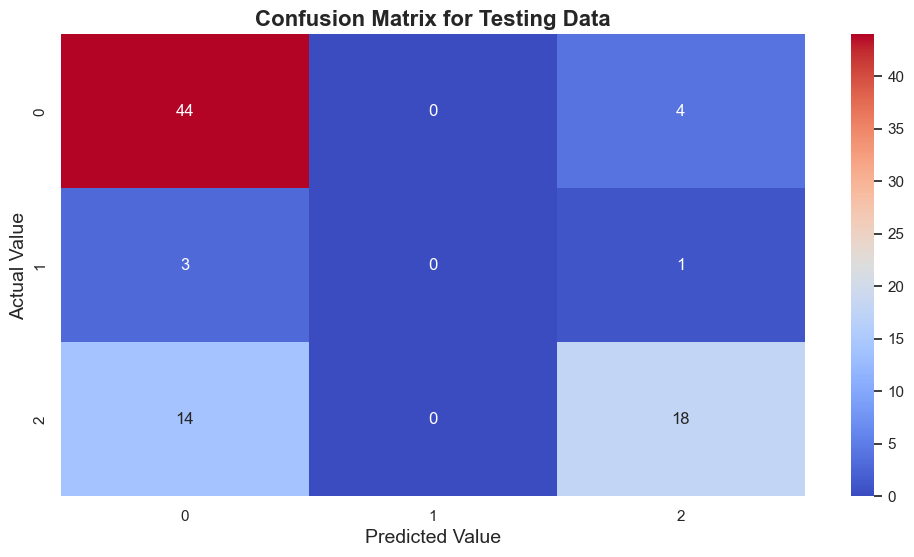

In [108]:
# Plotting confusion matrix for testing data
plt.figure(figsize=(12,6))
plt.title("Confusion Matrix for Testing Data", fontsize=16, fontweight="bold")
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt="g", cmap="coolwarm")
plt.xlabel("Predicted Value", fontsize=14)
plt.ylabel("Actual Value", fontsize=14)

Our confusion matrix shows that the model accuracy predicts the label 0 (classified) when the actual value is 0 reliably for the category. However, for instances with an actual value of 2 (death), the model frequently misclassifies them, predicting both 0 and 2.

With a score of 0.7381, we can say that our classifier performed moderately well, but that it has room for improvement. Some ways in which we could improve our model's performance include testing alternative hyperparameters such as the number of neighbors or metrics, or improving the quality of the features used. 